<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/deepxde_Adam%2BL-BFGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Neural Network Solution for ODE with Hill-Type Nonlinearity
**Goal**: Numerically solve an ODE with a Hill-type nonlinearity using DeepXDE.

- **Equation**: `dx/dt = x^(1/\u03b1) / (b^(1/\u03b1) + x^(1/\u03b1))`
- **Context**:
  - This is not the classical Hill equation but contains a Hill-type function.
  - This form appears in simplified gene regulation models.
- **Conditions**:
  - $ \alpha \to 0 $ (small, stiff regime)
  - $ x(0) \approx b $ (initial condition close to $b$)
- **Method**:
  - Physics-Informed Neural Network (PINN) with a 4-layer FNN (tanh activations).
  - Adam optimizer (LR=0.001).
- **Output**: Predicted `x(t)` compared with an approximate analytical solution.


- **Why RK45?** 🤔:  
  The `solve_ivp(method='RK45')` solver (Runge–Kutta 4–5 order) is:  
  - **Adaptive**: Adjusts step size for stiff regions (critical when 𝛼→0).  
  - **High-precision**: 5th-order local accuracy → "ground truth" for PINN comparisons.  
  - **Robust**: Handles near-step-function RHS (𝑥^(1/𝛼) becomes discontinuous as 𝛼→0).  

In [ ]:
# Parameters
alpha = 0.01
b = 1.0
x0 = b * 0.99999  # Initial condition x(0) ≈ b

!pip install deepxde
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


Training model: FNN 32x4, domain=500
Compiling model...
Building feed-forward neural network...
'build' took 0.086532 s

'compile' took 1.527108 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.56e-01, 1.00e-10]    [2.56e-01, 1.00e-10]    []  
1000      [1.79e-03, 8.10e-04]    [1.77e-03, 8.10e-04]    []  
2000      [8.30e-04, 1.24e-03]    [8.21e-04, 1.24e-03]    []  
3000      [6.38e-04, 1.32e-03]    [6.32e-04, 1.32e-03]    []  
4000      [5.26e-04, 1.35e-03]    [5.23e-04, 1.35e-03]    []  
5000      [4.22e-04, 1.40e-03]    [4.20e-04, 1.40e-03]    []  

Best model at step 5000:
  train loss: 1.82e-03
  test loss: 1.82e-03
  test metric: []

'train' took 18.673096 s

Compiling model...
'compile' took 1.833937 s

Training model...

Step      Train loss              Test loss               Test metric
5000      [4.22e-04, 1.40e-03]    [4.20e-04, 1.40e-03]    []  
5018      [4.22e-04, 1.40e-03]    [4.20e-04, 1.40e-03]    []  

Best m

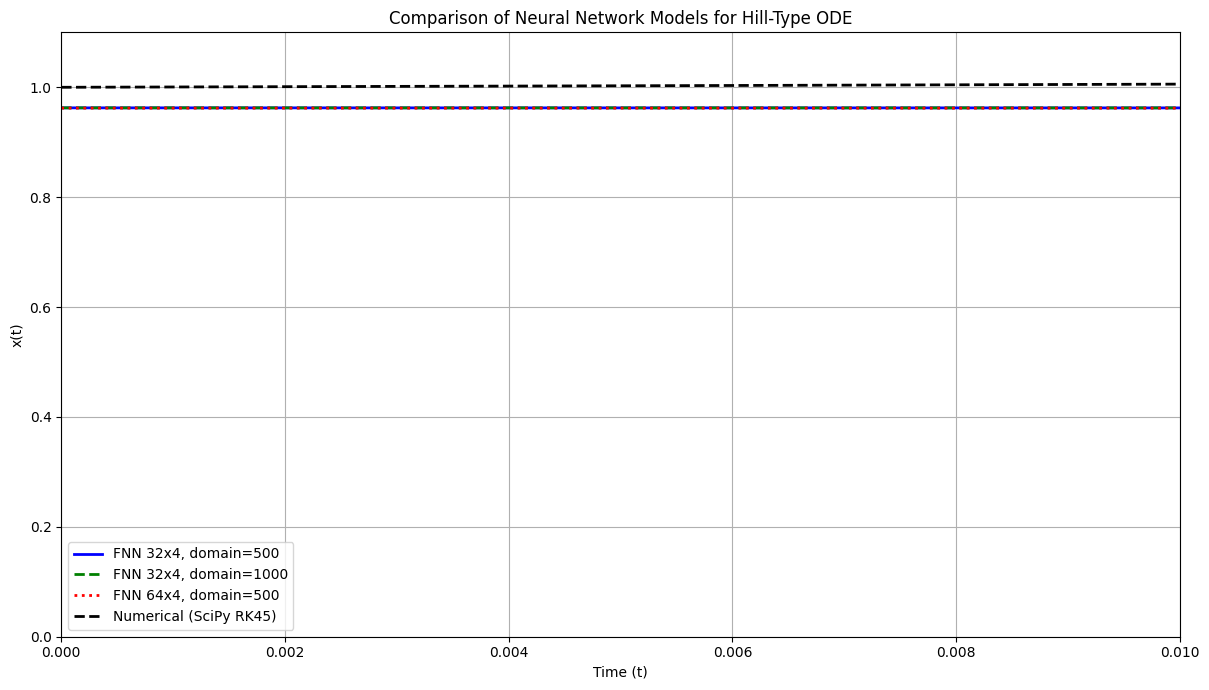

In [14]:
# Solution of ODE with Hill-like RHS: model comparison and approximation

# ODE with Hill-like RHS
# ODE definition with safety checks
def hill_equation(x, y):
    y_safe = tf.clip_by_value(y, 1e-6, 1e6)  # Avoid division by zero and overflows
    dy_t = dde.grad.jacobian(y, x, i=0, j=0)  # dy/dt
    x_alpha = tf.pow(y_safe, 1/alpha)         # x^(1/alpha)
    b_alpha = tf.pow(b, 1/alpha)              # b^(1/alpha)
    return dy_t - x_alpha / (b_alpha + x_alpha)


# Time domain geometry
geom = dde.geometry.TimeDomain(0, 1)

# Initial condition: x(0) ≈ b
ic = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

# Configurations to compare
#configs = [
#    (500, [1] + [32] * 4 + [1], "FNN 32x4, domain=500"),
#    (1000, [1] + [32] * 4 + [1], "FNN 32x4, domain=1000"),
#    (500, [1] + [128] * 6 + [1], "FNN 128x6, domain=500"),
#    (1000, [1] + [128] * 6 + [1], "FNN 128x6, domain=1000"),
#    (500, [1] + [128] * 8 + [1], "FNN 128x8, domain=500"),
#    (1000, [1] + [128] * 8 + [1], "FNN 128x8, domain=1000")
#]

configs = [
    (500, [1] + [32] * 4 + [1], "FNN 32x4, domain=500"),
    (1000, [1] + [32] * 4 + [1], "FNN 32x4, domain=1000"),
    (500, [1] + [64] * 4 + [1], "FNN 64x4, domain=500"),  # Упрощенная архитектура
]

# Prepare test time points
t_test = np.linspace(0, 1, 500).reshape(-1, 1)

# Solve the ODE numerically using SciPy (near-exact solution)
def rhs(t, x):
    x_safe = np.clip(x, 1e-6, 1e6)
    x_alpha = x_safe ** (1 / alpha)
    b_alpha = b ** (1 / alpha)
    return x_alpha / (b_alpha + x_alpha)

sol = solve_ivp(rhs, [0, 1], [x0], t_eval=t_test.flatten(), method='RK45')
x_exact = sol.y[0]

# Plot all models
plt.figure(figsize=(12, 7))

styles = ['-', '--', ':', '-.', 'dashed', 'dotted']
colors = ['b', 'g', 'r', 'c', 'm', 'k']

for i, (num_domain, architecture, label) in enumerate(configs):
    print(f"\nTraining model: {label}")

    data = dde.data.PDE(
        geom,
        hill_equation,
        ic,
        num_domain=num_domain,
        num_boundary=2, # 4
        num_test=500
    )
    net = dde.nn.FNN(architecture, "tanh", "Glorot normal")

    # Scale the neural network output
    net.apply_output_transform(lambda x, y: y * 0.01 + b)

    model = dde.Model(data, net)

    # Train with Adam optimizer
    model.compile("adam", lr=0.0001) # 0.001
    loss_history, train_state = model.train(
        iterations=5000,
        display_every=1000,
        disregard_previous_best=True
    )

    # Fine-tune with L-BFGS
    try:
        model.compile("L-BFGS")
        model.train(iterations=500)
    except Exception as e:
        print(f"L-BFGS failed for {label}: {str(e)}")

    # Предсказание и вывод результатов
    # Predict and plot
    x_pred = model.predict(t_test)
    print(f"{label}: min={np.nanmin(x_pred):.4f}, max={np.nanmax(x_pred):.4f}")

    plt.plot(t_test, x_pred,
             linestyle=styles[i], color=colors[i], label=label, linewidth=2)


# Plot the near-exact numerical solution
plt.plot(t_test, x_exact, 'k--', label='Numerical (SciPy RK45)', linewidth=2)

# Finalize the plot
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Comparison of Neural Network Models for Hill-Type ODE")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.autoscale(enable=True, axis='both', tight=True)
#plt.ylim(-0.1, 2.0)  # y 0.962, 0.974
#plt.xlim(0, 1.5)     # x 0, 1
# Set axis limits manually to prevent visual flattening
#plt.ylim(0.962, 0.974)
#plt.ylim(0.95, 0.974)
plt.ylim(0, 1.1)
#plt.xlim(0, 1)
plt.xlim(0, 0.01)

plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.083012 s

'compile' took 0.758325 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.40e-03, 1.00e+00]    [2.40e-03, 1.00e+00]    []  
100       [1.09e-03, 1.38e-03]    [1.09e-03, 1.38e-03]    []  
200       [5.02e-04, 1.57e-03]    [5.04e-04, 1.57e-03]    []  
300       [4.21e-04, 1.52e-03]    [4.23e-04, 1.52e-03]    []  
400       [3.73e-04, 1.48e-03]    [3.74e-04, 1.48e-03]    []  
500       [3.42e-04, 1.46e-03]    [3.43e-04, 1.46e-03]    []  
600       [3.24e-04, 1.43e-03]    [3.25e-04, 1.43e-03]    []  
700       [3.15e-04, 1.42e-03]    [3.15e-04, 1.42e-03]    []  
800       [3.13e-04, 1.40e-03]    [3.13e-04, 1.40e-03]    []  
900       [3.14e-04, 1.39e-03]    [3.14e-04, 1.39e-03]    []  
1000      [3.18e-04, 1.38e-03]    [3.17e-04, 1.38e-03]    []  
1100      [3.21e-04, 1.37e-03]    [3.21e-04, 1.37e-03]    []  
1200      [3.24e-04, 1.37e-03]    [3.23e-04,

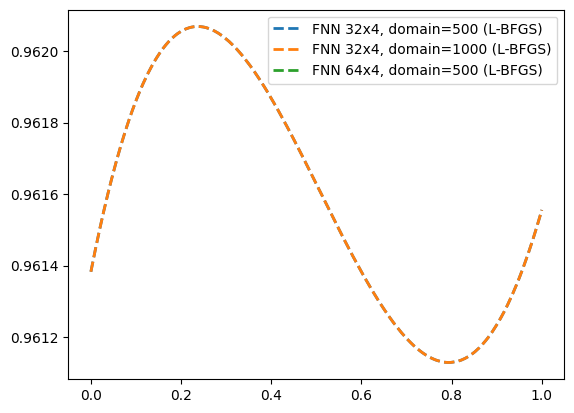

In [7]:
# --- L-BFGS Fine-Tuning (after Adam) ---
# Note: Run this AFTER initial training with Adam
# Purpose: Further refine the solution for better accuracy

for num_domain, architecture, label in configs:
    # Re-initialize model (optional, but ensures clean state)
    net = dde.nn.FNN(architecture, "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # Step 1: Train with Adam first
    model.compile("adam", lr=0.001)
    model.train(iterations=3000, display_every=100)

    # Step 2: Switch to L-BFGS for fine-tuning
    model.compile("L-BFGS")  # No learning rate needed
    model.train(iterations=1000)  # Usually needs fewer iterations

    # Optional: Plot the L-BFGS refined solution
    x_pred_lbfgs = model.predict(t_test)
    plt.plot(t_test, x_pred_lbfgs, '--', linewidth=2, label=f"{label} (L-BFGS)")

plt.legend()
plt.show()

# ⚡ Approximate Solution with Heaviside Step Function  
This code solves the same ODE using an explicit Heaviside step-function approximation for the limit case when $\alpha \to 0$.  
It gives a simple, interpretable solution used for comparison with neural network predictions.  


In [8]:
# Approximate solution using improved Heaviside step-like logic
# For small alpha, the function behaves like a steep sigmoid
x_heaviside = b * (1 - np.exp(-100 * t))

plt.figure(figsize=(10, 5))
plt.plot(t, x_heaviside, 'k--', label='Heaviside-like Approximation')
plt.ylim([0, b + 0.1])
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Steep Step-like Approximate Solution for α → 0")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 't' is not defined

In [ ]:
# Fourier approximation using another method (e.g., SciPy solve_ivp)
from scipy.integrate import solve_ivp

# Define the RHS of the ODE for SciPy
def rhs(t, x):
    x_alpha = x ** (1 / alpha)
    b_alpha = b ** (1 / alpha)
    return x_alpha / (b_alpha + x_alpha)

# Solve the ODE numerically
sol = solve_ivp(rhs, [0, 3], [x0], t_eval=t.flatten(), method='RK45')

plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], 'g-', label='SciPy RK45 Solution')
plt.xlabel("Time (t)")
plt.ylabel("x(t)")
plt.title("Numerical Solution of Hill-Type ODE via SciPy")
plt.legend()
plt.grid(True)
plt.show()